In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('data.txt','\t')

In [3]:
normalized_data = data.copy()
# normalize X
high = data['X'].max()
low = data['X'].min()
normalized_data['X'] = ((data['X'] - low) / (high - low)) * 10 # within [-0.1,0.1]

# normalize Y
high = data['Y'].max()
low = data['Y'].min()
normalized_data['Y'] = ((data['Y'] - low) / (high - low)) * 10 # within [-0.1,0.1]

# timestamp / 40
normalized_data['timestamp'] = (data['timestamp'] / 40).map(int)

In [4]:
normalized_data.to_csv('data_normalized.csv')

In [10]:
# functions for generate a batch of sample
'''
    Input:
        data: the CSV
        num_data: size of batch
    Output:
        IDs: list of selected IDs
        input_sequence: batch with shape (num_data,input_length, 2)
        output_sequence: batch with shape (num_data, output_length, 2)
'''
from random import shuffle
def get_batch(data,num_data = 128,input_length = 8, output_length = 4):
    # evaluate the total length of series required
    total_length = input_length + output_length
    # filter out the series that has at least the number of `total_length` long
    id_counts = data.groupby('ID').ID.count()
    # get a table of candidate id, whose sequence is longer than (or eq. to) total_length
    candidate_id_counts = id_counts[id_counts >= total_length]
    # get the random sequence...
    # the candidate_id_counts is a series with ID as x and count as y
    # to get the usable indices, get list series as a list of tuple like (id, count),
    # then take the first one (list of id)
    # and make it a list, and shuffle on it
    random_ids_selected = list(map(lambda tup: tup[0],candidate_id_counts.items()))
    shuffle(random_ids_selected)
    
    selected_ids = []
    input_batch = []
    target_batch = []
    # retrieve the coordinates of the sequence (from the beginning to `total_length`)
    for i in random_ids_selected[:num_data]:
        selected_ids.append(i)
        # select X,Y from ID where ID == i order by timestamp...
        sequence_of_i = data[data.ID == i].sort_values(by = "timestamp")[["X","Y"]]
        # divide the sequence into two parts...
        input_sequence = sequence_of_i.iloc[:input_length]
        target_sequence = sequence_of_i.iloc[input_length:total_length]
        # and append the new sequence to existing arrays
        input_batch.append(np.array(input_sequence))
        target_batch.append(np.array(target_sequence))
    
    # return and array of selected ids as well as the batch...
    return np.stack(selected_ids), np.stack(input_batch), np.stack(target_batch)
    

# verify the shape is right...
list(map(lambda a: a.shape,get_batch(normalized_data)))
    

[(128,), (128, 8, 2), (128, 4, 2)]

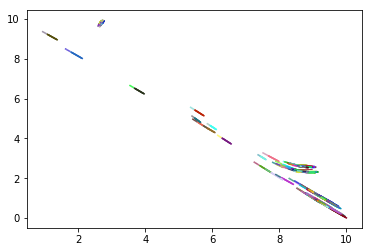

In [11]:
'''
    Visualize the traces in a batch
    If batch size = B, sequence length = L...
    Input:
        batch: batch of sequence of arbitrary length, i.e. array of shape (B,L,2)
    Output:
        None, a graph will be drawn instead..
'''

import matplotlib.pyplot as plt
def visualize_trace(batch,target_batch):
    # first we make sure that the shape of the batch looks like (_, _, 2)
    def check_shape(shape):
        if len(shape) != 3:
            raise ValueError("batch should be in 3 dimension")
        if shape[-1] != 2:
            raise ValueError("Last axis should be storing X,Y coordinates")
    
    check_shape(batch.shape)
    check_shape(target_batch.shape)
    # sub-routine for draw a particular batch
    def draw_batch(batch,linestyle = None):
        # now extract the dimension
        batch_size, sequence_length, _ = batch.shape
        for batch_id in range(batch_size):
            # pick a random color for this trace
            line_color = np.random.rand(3)
            for sequence_pos in range(sequence_length - 1):
                # get the two adjacent coordinates
                cur_coord = batch[batch_id, sequence_pos]
                next_coord = batch[batch_id, sequence_pos + 1]
                # and draw the line...
                # sneaky plot function requires x-coordinates to be put in the same argument, so are y-coordinates...
                plt.plot([cur_coord[0],next_coord[0]],
                         [cur_coord[1],next_coord[1]],
                         linestyle = linestyle,
                         c = line_color)
    
    draw_batch(batch)
    draw_batch(target_batch, ":")
    # finally show the graph
#     plt.show()
    
# let's test this visualization,
_, input_batch, target_batch = get_batch(normalized_data,128,16,8)
visualize_trace(input_batch,target_batch)

In [12]:
# now lets define a vanilla LSTM model
'''
    According to the paper, there should be an RNN that takes a sequence and gives a sequence (like seq-to-seq)
    except this output are hidden layers, like vectors of length 128
    To interpret such result, a dense layer with ReLU is added to condense the output to 5 numbers,
    namely, the mean_x, mean_y, sxx, syy, and sxy 
    of the bivariate gaussian of the probability of the agent at that given timestamp.
    
    The negative log likelihood between the real coordinate and this estimated distribution will be the loss.
'''
# first, the loss function, in Keras backend
from keras.layers import *
import keras.backend as K
'''
    The function takes a series of params of bivariate normal distribution, and a batch of observed coordinates,
    and return the log likelikhood of them...
    
    probability (likelihood) of the observed point (x,y) given the 5 parameters (mx,my,sx,sy,sp):
        det(2 * pi * [[sx,sp],[sp,sy]]) ^(-0.5) 
            * exp(-0.5 * ((x,y) - (mx,my)).T * [[sx,sp],[sp,sy]] * ((x,y) - (mx,my)))
    
    after taking log and add a minus (* -1)...
        -( (-0.5 * log(4 * pi ^ 2 * sx * sy - sp * sp)) + (-0.5 * (...)))
    
    If batch size = B, sequence length = D...
    Input:
        Batch bivariate parameters (estimated): K.variable with shape (B,D,5),
        Batch of overserved coordinates (label): K.variable with shape (B,D,2)
    
    Output:
        a scaler (K.variable with shape ()), which is the sum of negative log likelihood
'''

def negative_log_likelihood_loss(batch_observed_coordinates,batch_bivariate_params):
    # first check the dimension...
    input_shape = K.int_shape(batch_bivariate_params)
    target_shape = K.int_shape(batch_observed_coordinates)
    
    if len(input_shape) != 3 or len(target_shape) != 3:
        raise ValueError("Dimension of both tensors should be 3")
    
    if input_shape[0] != target_shape[0]:
        raise ValueError("Batch size of both tensors should be the same")
    
    if input_shape[1] != target_shape[1]:
        raise ValueError("Sequence length of both tensors should be the same")
    
    if input_shape[2] != 5:
        raise ValueError("Number of predicted parameters should be 5. Namely, (mx,my,sx,sy,sp)")
    
    if target_shape[2] != 2:
        raise ValueError("Dimension of target coordinates should be 2. Namely, (x,y)")
    
    # then split the tensors into (mx,my,sx,sy,sp)...
    # all of them should be of shape (B,D)
    batch_mx = batch_bivariate_params[:,:,0]
    batch_my = batch_bivariate_params[:,:,1]
    batch_sx = batch_bivariate_params[:,:,2]
    batch_sy = batch_bivariate_params[:,:,3]
    batch_sp = batch_bivariate_params[:,:,4]
    
    batch_x = batch_observed_coordinates[:,:,0]
    batch_y = batch_observed_coordinates[:,:,1]
    
    dx = batch_x - batch_mx # (B,D), (x - mx)
    dy = batch_y - batch_my # (B,D), (y - my)
    dydx = Multiply()([dx,dy])
    
    batch_x_change =  K.concatenate([batch_mx[:,0:1], batch_mx[:,1:] - batch_mx[:,:-1]])
    batch_y_change =  K.concatenate([batch_my[:,0:1], batch_my[:,1:] - batch_my[:,:-1]])
    target_x_change =  K.concatenate([batch_x[:,0:1], batch_x[:,1:] - batch_x[:,:-1]])
    target_y_change =  K.concatenate([batch_y[:,0:1], batch_y[:,1:] - batch_y[:,:-1]])
    
    xy_dot = Multiply()([batch_x_change,target_x_change]) + Multiply()([batch_y_change,target_y_change])
    batch_change_norm = K.sqrt(K.square(batch_x_change) + K.square(batch_y_change))
    target_change_norm = K.sqrt(K.square(target_x_change) + K.square(target_y_change))
    
    norm_prod = Multiply()([batch_change_norm,target_change_norm]) + 1e-6
    norm_prod_inv = K.pow(norm_prod,-1) # for numerical stability
    direction_loss =  - K.mean(Multiply()([xy_dot,norm_prod_inv]))
#     det_inv = K.print_tensor(K.pow(det,-1), message="det_inv") # (B,D), (sx * sy - sp^2) ^-1
    # (B,D), (dx^2 * sy - 2 * sp * dy * dx + sx * dy^2)
    exp = -0.5 * Multiply()([K.square(dx),batch_sy]) - 2 * Multiply()([dydx, batch_sp]) + Multiply()([K.square(dy),batch_sx])
    # (B,D), -0.5 * (dx^2 * sy - 2 * sp * dy * dx + sx * dy^2) * det(Cov)^(-1)
#     exp = Multiply()([det_inv,exp]) * (-0.5)
    
    # evaluate the final NLL
    '''
        A remark here: it is determined that the determininat of the covariance matrix will not be considered as a loss,
        as the value of that generally became very large (under the log function)
        therefore only the exponents are used as the loss
    '''
#     batch_nll = - (exp)
    batch_nll = K.square(dx) + K.square(dy) - 0.1 * exp + 0.1 * direction_loss
    batch_error_total = K.sum(batch_nll, axis = 1) # (B,) sum of NLL in a sequence...
    return K.print_tensor(K.mean(batch_error_total, axis = 0)) # (), average of sum of NLL...

# now test it...
# a regular 0-centered, non-skewing normal
[mx,my,sx,sy,sp] = [0,0,.1,.1,0.]
bivariate_params = np.array([[[mx,my,sx,sy,sp]]]) # (1,1,5)
target_point = np.array([[[-0.,0]]]) # (1,1,2)

bivariate_ph = K.variable(value = bivariate_params, dtype = "float32")
target_ph = K.variable(value = target_point, dtype = "float32")
nll = negative_log_likelihood_loss(target_ph,bivariate_ph)
K.eval(nll)

0.0

In [13]:
def infer_layer(batch_predicted_coordinates):
    return K.cumsum(batch_predicted_coordinates,axis = 1)
    
def check_tensor(batch_observed_coordinates,batch_predicted_coordinates):
    input_shape = K.int_shape(batch_predicted_coordinates)
    target_shape = K.int_shape(batch_observed_coordinates)

    if len(input_shape) != 3 or len(target_shape) != 3:
        raise ValueError("Dimension of both tensors should be 3")

    if input_shape[0] != target_shape[0]:
        raise ValueError("Batch size of both tensors should be the same")

    if input_shape[1] != target_shape[1]:
        raise ValueError("Sequence length of both tensors should be the same")

    if input_shape[2] != 2:
        raise ValueError("Number of predicted parameters should be 2. Namely, (mx,my)")

    if target_shape[2] != 2:
        raise ValueError("Dimension of target coordinates should be 2. Namely, (x,y)")
    
def ms_loss(input_tensor):
    batch_observed_coordinates,batch_predicted_coordinates = input_tensor
    # first check the dimension...
    check_tensor(batch_observed_coordinates,batch_predicted_coordinates)
    
    diff = K.square(batch_predicted_coordinates - batch_observed_coordinates)

    return K.sum(diff)

def dir_loss(input_tensor):
    batch_observed_coordinates,batch_predicted_coordinates = input_tensor
    check_tensor(batch_observed_coordinates,batch_predicted_coordinates)
    
    predict_dir = batch_predicted_coordinates[:,1:] - batch_predicted_coordinates[:,:-1]
    
    target_dir = batch_observed_coordinates[:,1:] - batch_observed_coordinates[:,:-1]
    
#     predic_dir_norm = 
    # this is to maximize the cosine (therefore angle = 0)
    return K.sum(K.square((predict_dir - target_dir)))

In [14]:
# then, the Vanilla LSTM
from keras.models import Model
from keras.initializers import RandomNormal
from keras import optimizers
def vanilla_lstm_model(num_hidden, input_length, predict_length, lr = 1e-3):
# def vanilla_lstm_model(num_hidden,input_length, predict_length, input_tensor, target_tensor):
    total_length = input_length + predict_length
    # the input
    input_sequence = Input(shape = (total_length,2), name = 'input_sequence', dtype = 'float32') # (T, 2)
    target_sequence = Input(shape = (total_length,2), name = 'target_sequence', dtype = 'float32') # (T, 2)
    lstm = LSTM(num_hidden, return_sequences = True)(input_sequence) # (B,T,num_hidden)
#     params = TimeDistributed(Dense(5, activation = 'elu'), name = 'params')(lstm) # (B,T,5)
    predicted_coordinates_raw = TimeDistributed(Dense(2, activation = 'elu'), name = 'params')(lstm)
    
    # retrieve the prediction
    extract_target_sequence_layer = Lambda(lambda x: x[:,input_length:,:])
    predicted_coordinates_masked = extract_target_sequence_layer(predicted_coordinates_raw)
    target_coordinates_masked = extract_target_sequence_layer(target_sequence)
    # the output layer
    predicted_output = Lambda(infer_layer, name = "predict")(predicted_coordinates_masked)
    # compute the loss
    
    # first part: the square loss
    sq_loss = Lambda(ms_loss, name = 'square_loss')([target_coordinates_masked, predicted_output])
    # second part: the direction loss
    ori_loss = Lambda(dir_loss, name = 'dir_loss')([target_coordinates_masked, predicted_output])
    
    loss = Lambda(lambda ts: ts[0] + ts[1],name = 'loss')([sq_loss, ori_loss])
    
    model = Model(
        inputs = [input_sequence,target_sequence],
        outputs = [predicted_output,loss])
    
    model.compile(optimizer=optimizers.RMSprop(lr = lr, clipvalue = 10., decay = 1e-6),
                  # since there are two outputs of the model, the estimated params and the NLL,
                  # their loss value should be specified.
                  # for params there are no loss regarding its value, but I just assign a zero as loss (or the computational graph will break)
                  # I made it loss - loss = 0.
                  # and for the NLL, return the loss as-is.
                  loss= {
                        'predict': lambda _, loss: loss - loss, # meh...
                          'loss': lambda _, loss: loss
                    })
    
    return input_sequence, target_sequence, model, predicted_output,loss




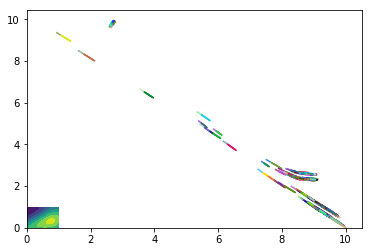

In [15]:
# helper function for monitoring training progress
from scipy.stats import multivariate_normal
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
'''
    Given a set of parameter (array of 5), visualize the heatmap of the bivariate normal distribution
'''
def draw_heatmap(params):
    resolution = 100
    interval = 1. / resolution
    
    x,y = np.mgrid[0:1:interval,0:1:interval]
    pos = np.empty(x.shape + (2,))
    pos[:,:,0] = x
    pos[:,:,1] = y
    result_distribution = None
    for param in params:
        mx,my,sx,sy,sp = param
        F = multivariate_normal([mx,my],[[sx,sp],[sp,sy]])
        result_distribution = F.pdf(pos) if result_distribution is None else result_distribution + F.pdf(pos)
    plt.contourf(x,y,result_distribution)

# try it out
# fig = plt.figure()
draw_heatmap(np.array([[0.3,0.1,0.4,0.2,.2],[0.9,0.2,0.1,0.9,0.]]))
visualize_trace(input_batch,target_batch)
# draw_heatmap(0.3,0.2,0.01,0.2,0.,fig)
plt.show()

'''
    Draw the mean of the predicted params of all timestamps
'''
import matplotlib.cm as cm
def draw_mean(params):
    plt.xlim(0,10)
    plt.ylim(0,10)
    
    
    for batch in range(params.shape[0]):
        line_color = np.random.rand(3) # choose a color to tell that these scatter points belong to the same prediction
        xy_series = params[batch,:,:] # (D,2)
        # prgressively change the color to indicate the direction
        colors = cm.rainbow(np.linspace(0, 1, params.shape[1]))
        plt.scatter(xy_series[:,0],xy_series[:,1], c = colors)

In [36]:
from keras.callbacks import ReduceLROnPlateau, CSVLogger, LambdaCallback
def get_callbacks(input_batch_padded,target_batch_padded,finetune = False):
    # prepare callbacks
    reduce_lr = ReduceLROnPlateau(monitor='loss', 
                                  factor=0.5,
                                  patience=50, 
                                  min_lr=1e-6)
    csv_logger = CSVLogger("log.csv")

    def visualize_prediction(epoch, logs):
        params, loss = model.predict([input_batch_padded,target_batch_padded])
        # visualize the trace, as well as the distributions generated by the params...
        # first clear the previous drawing...
    #     try:
        plt.gcf().clear()
        visualize_trace(input_batch,target_batch)
    #     params = params[:,INPUT_LENGTH + 1, :] # (B,5), and it should be the params immediately after the input
    #     draw_heatmap(params)
        draw_mean(params)
        filename = '{}.png' if not finetune else '{}-finetune.png'
        plt.savefig(filename.format(epoch))

    plot_callback = LambdaCallback(on_epoch_begin = visualize_prediction)
    
    return [reduce_lr, 
            csv_logger,
           # plot_callback
           ]

In [37]:
# now run the training!
INPUT_LENGTH = 8
OUTPUT_LENGTH = 8
TOTAL_LENGTH = INPUT_LENGTH + OUTPUT_LENGTH
BATCH_SIZE = 256

inp_ph,target_ph, model, params, loss = vanilla_lstm_model(128,
                                                           INPUT_LENGTH,
                                                           OUTPUT_LENGTH,
                                                          1e-3)
model.summary()
indices, input_batch, target_batch = get_batch(normalized_data,BATCH_SIZE,INPUT_LENGTH,OUTPUT_LENGTH)

# prepare data
input_batch_padded = np.hstack([input_batch,np.zeros((BATCH_SIZE,OUTPUT_LENGTH,2))])
target_batch_padded = np.hstack([np.zeros((BATCH_SIZE,INPUT_LENGTH,2)),target_batch])


# and train
model.fit(
    [input_batch_padded,target_batch_padded],
    [np.zeros((BATCH_SIZE,TOTAL_LENGTH,2)),np.zeros(BATCH_SIZE)],
    epochs = 1500,
    validation_split = 0.2,
    callbacks = get_callbacks(input_batch_padded,target_batch_padded)
)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_sequence (InputLayer)     (None, 16, 2)        0                                            
__________________________________________________________________________________________________
lstm_10 (LSTM)                  (None, 16, 128)      67072       input_sequence[0][0]             
__________________________________________________________________________________________________
params (TimeDistributed)        (None, 16, 2)        258         lstm_10[0][0]                    
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 8, 2)         0           params[0][0]                     
                                                                 target_sequence[0][0]            
__________

204/204 [==============================] - 0s 759us/step - loss: 725.4391 - predict_loss: 0.0000e+00 - loss_loss: 725.4391 - val_loss: 628.0798 - val_predict_loss: 0.0000e+00 - val_loss_loss: 628.0798
Epoch 27/1500
204/204 [==============================] - 0s 613us/step - loss: 713.2060 - predict_loss: 0.0000e+00 - loss_loss: 713.2060 - val_loss: 410.4204 - val_predict_loss: 0.0000e+00 - val_loss_loss: 410.4204
Epoch 28/1500
204/204 [==============================] - 0s 638us/step - loss: 668.3244 - predict_loss: 0.0000e+00 - loss_loss: 668.3244 - val_loss: 562.8657 - val_predict_loss: 0.0000e+00 - val_loss_loss: 562.8657
Epoch 29/1500
204/204 [==============================] - 0s 629us/step - loss: 663.2917 - predict_loss: 0.0000e+00 - loss_loss: 663.2917 - val_loss: 386.3713 - val_predict_loss: 0.0000e+00 - val_loss_loss: 386.3713
Epoch 30/1500
204/204 [==============================] - 0s 718us/step - loss: 626.4989 - predict_loss: 0.0000e+00 - loss_loss: 626.4989 - val_loss: 523.2

204/204 [==============================] - 0s 770us/step - loss: 157.4170 - predict_loss: 0.0000e+00 - loss_loss: 157.4170 - val_loss: 74.4626 - val_predict_loss: 0.0000e+00 - val_loss_loss: 74.4626
Epoch 65/1500
204/204 [==============================] - 0s 767us/step - loss: 145.9061 - predict_loss: 0.0000e+00 - loss_loss: 145.9061 - val_loss: 55.3346 - val_predict_loss: 0.0000e+00 - val_loss_loss: 55.3346
Epoch 66/1500
204/204 [==============================] - 0s 704us/step - loss: 176.1611 - predict_loss: 0.0000e+00 - loss_loss: 176.1611 - val_loss: 60.5655 - val_predict_loss: 0.0000e+00 - val_loss_loss: 60.5655
Epoch 67/1500
204/204 [==============================] - 0s 612us/step - loss: 150.3481 - predict_loss: 0.0000e+00 - loss_loss: 150.3481 - val_loss: 33.7425 - val_predict_loss: 0.0000e+00 - val_loss_loss: 33.7425
Epoch 68/1500
204/204 [==============================] - 0s 639us/step - loss: 135.1877 - predict_loss: 0.0000e+00 - loss_loss: 135.1877 - val_loss: 44.5646 - val

Epoch 103/1500
204/204 [==============================] - 0s 533us/step - loss: 65.4573 - predict_loss: 0.0000e+00 - loss_loss: 65.4573 - val_loss: 18.3728 - val_predict_loss: 0.0000e+00 - val_loss_loss: 18.3728
Epoch 104/1500
204/204 [==============================] - 0s 553us/step - loss: 61.6312 - predict_loss: 0.0000e+00 - loss_loss: 61.6312 - val_loss: 12.7724 - val_predict_loss: 0.0000e+00 - val_loss_loss: 12.7724
Epoch 105/1500
204/204 [==============================] - 0s 561us/step - loss: 53.8914 - predict_loss: 0.0000e+00 - loss_loss: 53.8914 - val_loss: 15.9415 - val_predict_loss: 0.0000e+00 - val_loss_loss: 15.9415
Epoch 106/1500
204/204 [==============================] - 0s 593us/step - loss: 67.4557 - predict_loss: 0.0000e+00 - loss_loss: 67.4557 - val_loss: 12.1935 - val_predict_loss: 0.0000e+00 - val_loss_loss: 12.1935
Epoch 107/1500
204/204 [==============================] - 0s 620us/step - loss: 52.7111 - predict_loss: 0.0000e+00 - loss_loss: 52.7111 - val_loss: 21.3

Epoch 142/1500
204/204 [==============================] - 0s 610us/step - loss: 43.0718 - predict_loss: 0.0000e+00 - loss_loss: 43.0718 - val_loss: 14.2300 - val_predict_loss: 0.0000e+00 - val_loss_loss: 14.2300
Epoch 143/1500
204/204 [==============================] - 0s 608us/step - loss: 40.2711 - predict_loss: 0.0000e+00 - loss_loss: 40.2711 - val_loss: 9.1002 - val_predict_loss: 0.0000e+00 - val_loss_loss: 9.1002
Epoch 144/1500
204/204 [==============================] - 0s 642us/step - loss: 38.3358 - predict_loss: 0.0000e+00 - loss_loss: 38.3358 - val_loss: 6.3239 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.3239
Epoch 145/1500
204/204 [==============================] - 0s 601us/step - loss: 37.4621 - predict_loss: 0.0000e+00 - loss_loss: 37.4621 - val_loss: 7.8759 - val_predict_loss: 0.0000e+00 - val_loss_loss: 7.8759
Epoch 146/1500
204/204 [==============================] - 0s 575us/step - loss: 30.6785 - predict_loss: 0.0000e+00 - loss_loss: 30.6785 - val_loss: 8.5707 - v

Epoch 181/1500
204/204 [==============================] - 0s 593us/step - loss: 27.7643 - predict_loss: 0.0000e+00 - loss_loss: 27.7643 - val_loss: 14.4787 - val_predict_loss: 0.0000e+00 - val_loss_loss: 14.4787
Epoch 182/1500
204/204 [==============================] - 0s 607us/step - loss: 38.8281 - predict_loss: 0.0000e+00 - loss_loss: 38.8281 - val_loss: 14.3693 - val_predict_loss: 0.0000e+00 - val_loss_loss: 14.3693
Epoch 183/1500
204/204 [==============================] - 0s 602us/step - loss: 23.1660 - predict_loss: 0.0000e+00 - loss_loss: 23.1660 - val_loss: 6.2135 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.2135
Epoch 184/1500
204/204 [==============================] - 0s 594us/step - loss: 28.4225 - predict_loss: 0.0000e+00 - loss_loss: 28.4225 - val_loss: 11.4047 - val_predict_loss: 0.0000e+00 - val_loss_loss: 11.4047
Epoch 185/1500
204/204 [==============================] - 0s 604us/step - loss: 23.3427 - predict_loss: 0.0000e+00 - loss_loss: 23.3427 - val_loss: 9.2260

Epoch 220/1500
204/204 [==============================] - 0s 668us/step - loss: 23.0730 - predict_loss: 0.0000e+00 - loss_loss: 23.0730 - val_loss: 6.2328 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.2328
Epoch 221/1500
204/204 [==============================] - 0s 500us/step - loss: 27.7890 - predict_loss: 0.0000e+00 - loss_loss: 27.7890 - val_loss: 6.7051 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.7051
Epoch 222/1500
204/204 [==============================] - 0s 570us/step - loss: 18.6299 - predict_loss: 0.0000e+00 - loss_loss: 18.6299 - val_loss: 8.1647 - val_predict_loss: 0.0000e+00 - val_loss_loss: 8.1647
Epoch 223/1500
204/204 [==============================] - 0s 633us/step - loss: 27.1161 - predict_loss: 0.0000e+00 - loss_loss: 27.1161 - val_loss: 5.8408 - val_predict_loss: 0.0000e+00 - val_loss_loss: 5.8408
Epoch 224/1500
204/204 [==============================] - 0s 644us/step - loss: 23.1960 - predict_loss: 0.0000e+00 - loss_loss: 23.1960 - val_loss: 8.4993 - val

Epoch 259/1500
204/204 [==============================] - 0s 590us/step - loss: 29.7931 - predict_loss: 0.0000e+00 - loss_loss: 29.7931 - val_loss: 5.9951 - val_predict_loss: 0.0000e+00 - val_loss_loss: 5.9951
Epoch 260/1500
204/204 [==============================] - 0s 620us/step - loss: 16.3345 - predict_loss: 0.0000e+00 - loss_loss: 16.3345 - val_loss: 4.8087 - val_predict_loss: 0.0000e+00 - val_loss_loss: 4.8087
Epoch 261/1500
204/204 [==============================] - 0s 555us/step - loss: 24.8365 - predict_loss: 0.0000e+00 - loss_loss: 24.8365 - val_loss: 6.4450 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.4450
Epoch 262/1500
204/204 [==============================] - 0s 667us/step - loss: 22.0485 - predict_loss: 0.0000e+00 - loss_loss: 22.0485 - val_loss: 5.1379 - val_predict_loss: 0.0000e+00 - val_loss_loss: 5.1379
Epoch 263/1500
204/204 [==============================] - 0s 577us/step - loss: 18.5093 - predict_loss: 0.0000e+00 - loss_loss: 18.5093 - val_loss: 6.1417 - val

Epoch 298/1500
204/204 [==============================] - 0s 585us/step - loss: 21.4639 - predict_loss: 0.0000e+00 - loss_loss: 21.4639 - val_loss: 6.2553 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.2553
Epoch 299/1500
204/204 [==============================] - 0s 618us/step - loss: 19.5110 - predict_loss: 0.0000e+00 - loss_loss: 19.5110 - val_loss: 4.5131 - val_predict_loss: 0.0000e+00 - val_loss_loss: 4.5131
Epoch 300/1500
204/204 [==============================] - 0s 595us/step - loss: 18.1357 - predict_loss: 0.0000e+00 - loss_loss: 18.1357 - val_loss: 6.3350 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.3350
Epoch 301/1500
204/204 [==============================] - 0s 557us/step - loss: 24.7593 - predict_loss: 0.0000e+00 - loss_loss: 24.7593 - val_loss: 9.3862 - val_predict_loss: 0.0000e+00 - val_loss_loss: 9.3862
Epoch 302/1500
204/204 [==============================] - 0s 567us/step - loss: 18.4030 - predict_loss: 0.0000e+00 - loss_loss: 18.4030 - val_loss: 5.0072 - val

204/204 [==============================] - 0s 624us/step - loss: 25.2984 - predict_loss: 0.0000e+00 - loss_loss: 25.2984 - val_loss: 10.2043 - val_predict_loss: 0.0000e+00 - val_loss_loss: 10.2043
Epoch 338/1500
204/204 [==============================] - 0s 603us/step - loss: 14.0044 - predict_loss: 0.0000e+00 - loss_loss: 14.0044 - val_loss: 8.1869 - val_predict_loss: 0.0000e+00 - val_loss_loss: 8.1869
Epoch 339/1500
204/204 [==============================] - 0s 584us/step - loss: 17.0846 - predict_loss: 0.0000e+00 - loss_loss: 17.0846 - val_loss: 5.9247 - val_predict_loss: 0.0000e+00 - val_loss_loss: 5.9247
Epoch 340/1500
204/204 [==============================] - 0s 560us/step - loss: 16.8393 - predict_loss: 0.0000e+00 - loss_loss: 16.8393 - val_loss: 8.8433 - val_predict_loss: 0.0000e+00 - val_loss_loss: 8.8433
Epoch 341/1500
204/204 [==============================] - 0s 652us/step - loss: 25.0302 - predict_loss: 0.0000e+00 - loss_loss: 25.0302 - val_loss: 12.3133 - val_predict_los

204/204 [==============================] - 0s 631us/step - loss: 13.6092 - predict_loss: 0.0000e+00 - loss_loss: 13.6092 - val_loss: 8.5092 - val_predict_loss: 0.0000e+00 - val_loss_loss: 8.5092
Epoch 377/1500
204/204 [==============================] - 0s 587us/step - loss: 19.3104 - predict_loss: 0.0000e+00 - loss_loss: 19.3104 - val_loss: 6.8886 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.8886
Epoch 378/1500
204/204 [==============================] - 0s 576us/step - loss: 15.8212 - predict_loss: 0.0000e+00 - loss_loss: 15.8212 - val_loss: 6.0908 - val_predict_loss: 0.0000e+00 - val_loss_loss: 6.0908
Epoch 379/1500
204/204 [==============================] - 0s 519us/step - loss: 17.6507 - predict_loss: 0.0000e+00 - loss_loss: 17.6507 - val_loss: 9.9493 - val_predict_loss: 0.0000e+00 - val_loss_loss: 9.9493
Epoch 380/1500
204/204 [==============================] - 0s 585us/step - loss: 18.9068 - predict_loss: 0.0000e+00 - loss_loss: 18.9068 - val_loss: 6.4536 - val_predict_loss: 

204/204 [==============================] - 0s 558us/step - loss: 5.5029 - predict_loss: 0.0000e+00 - loss_loss: 5.5029 - val_loss: 1.9980 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.9980
Epoch 416/1500
204/204 [==============================] - 0s 568us/step - loss: 6.6515 - predict_loss: 0.0000e+00 - loss_loss: 6.6515 - val_loss: 3.7740 - val_predict_loss: 0.0000e+00 - val_loss_loss: 3.7740
Epoch 417/1500
204/204 [==============================] - 0s 632us/step - loss: 5.3580 - predict_loss: 0.0000e+00 - loss_loss: 5.3580 - val_loss: 2.5067 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.5067
Epoch 418/1500
204/204 [==============================] - 0s 574us/step - loss: 7.0237 - predict_loss: 0.0000e+00 - loss_loss: 7.0237 - val_loss: 2.3051 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.3051
Epoch 419/1500
204/204 [==============================] - 0s 563us/step - loss: 6.3406 - predict_loss: 0.0000e+00 - loss_loss: 6.3406 - val_loss: 3.8780 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 620us/step - loss: 9.0510 - predict_loss: 0.0000e+00 - loss_loss: 9.0510 - val_loss: 2.6959 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.6959
Epoch 455/1500
204/204 [==============================] - 0s 544us/step - loss: 4.6614 - predict_loss: 0.0000e+00 - loss_loss: 4.6614 - val_loss: 1.9355 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.9355
Epoch 456/1500
204/204 [==============================] - 0s 607us/step - loss: 5.1561 - predict_loss: 0.0000e+00 - loss_loss: 5.1561 - val_loss: 2.2414 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.2414
Epoch 457/1500
204/204 [==============================] - 0s 543us/step - loss: 6.5550 - predict_loss: 0.0000e+00 - loss_loss: 6.5550 - val_loss: 2.2318 - val_predict_loss: 0.0000e+00 - val_loss_loss: 2.2318
Epoch 458/1500
204/204 [==============================] - 0s 606us/step - loss: 5.5162 - predict_loss: 0.0000e+00 - loss_loss: 5.5162 - val_loss: 2.8025 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 598us/step - loss: 2.7634 - predict_loss: 0.0000e+00 - loss_loss: 2.7634 - val_loss: 0.9990 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.9990
Epoch 494/1500
204/204 [==============================] - 0s 522us/step - loss: 1.8765 - predict_loss: 0.0000e+00 - loss_loss: 1.8765 - val_loss: 1.1047 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.1047
Epoch 495/1500
204/204 [==============================] - 0s 545us/step - loss: 2.2953 - predict_loss: 0.0000e+00 - loss_loss: 2.2953 - val_loss: 0.9956 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.9956
Epoch 496/1500
204/204 [==============================] - 0s 625us/step - loss: 2.4695 - predict_loss: 0.0000e+00 - loss_loss: 2.4695 - val_loss: 0.9734 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.9734
Epoch 497/1500
204/204 [==============================] - 0s 616us/step - loss: 2.2613 - predict_loss: 0.0000e+00 - loss_loss: 2.2613 - val_loss: 0.9605 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 673us/step - loss: 2.2373 - predict_loss: 0.0000e+00 - loss_loss: 2.2373 - val_loss: 1.0772 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.0772
Epoch 533/1500
204/204 [==============================] - 0s 522us/step - loss: 2.0437 - predict_loss: 0.0000e+00 - loss_loss: 2.0437 - val_loss: 0.9462 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.9462
Epoch 534/1500
204/204 [==============================] - 0s 588us/step - loss: 2.3690 - predict_loss: 0.0000e+00 - loss_loss: 2.3690 - val_loss: 0.9227 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.9227
Epoch 535/1500
204/204 [==============================] - 0s 490us/step - loss: 1.9044 - predict_loss: 0.0000e+00 - loss_loss: 1.9044 - val_loss: 1.1493 - val_predict_loss: 0.0000e+00 - val_loss_loss: 1.1493
Epoch 536/1500
204/204 [==============================] - 0s 508us/step - loss: 1.9623 - predict_loss: 0.0000e+00 - loss_loss: 1.9623 - val_loss: 1.0294 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 657us/step - loss: 1.1798 - predict_loss: 0.0000e+00 - loss_loss: 1.1798 - val_loss: 0.6704 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.6704
Epoch 572/1500
204/204 [==============================] - 0s 528us/step - loss: 1.0458 - predict_loss: 0.0000e+00 - loss_loss: 1.0458 - val_loss: 0.7143 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.7143
Epoch 573/1500
204/204 [==============================] - 0s 555us/step - loss: 0.8560 - predict_loss: 0.0000e+00 - loss_loss: 0.8560 - val_loss: 0.6534 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.6534
Epoch 574/1500
204/204 [==============================] - 0s 582us/step - loss: 1.3722 - predict_loss: 0.0000e+00 - loss_loss: 1.3722 - val_loss: 0.7767 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.7767
Epoch 575/1500
204/204 [==============================] - 0s 598us/step - loss: 1.0713 - predict_loss: 0.0000e+00 - loss_loss: 1.0713 - val_loss: 0.6425 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 666us/step - loss: 0.9752 - predict_loss: 0.0000e+00 - loss_loss: 0.9752 - val_loss: 0.5530 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.5530
Epoch 611/1500
204/204 [==============================] - 0s 623us/step - loss: 1.0185 - predict_loss: 0.0000e+00 - loss_loss: 1.0185 - val_loss: 0.6405 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.6405
Epoch 612/1500
204/204 [==============================] - 0s 606us/step - loss: 1.0947 - predict_loss: 0.0000e+00 - loss_loss: 1.0947 - val_loss: 0.5197 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.5197
Epoch 613/1500
204/204 [==============================] - 0s 586us/step - loss: 1.0808 - predict_loss: 0.0000e+00 - loss_loss: 1.0808 - val_loss: 0.5272 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.5272
Epoch 614/1500
204/204 [==============================] - 0s 531us/step - loss: 0.8075 - predict_loss: 0.0000e+00 - loss_loss: 0.8075 - val_loss: 0.5528 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 633us/step - loss: 0.6922 - predict_loss: 0.0000e+00 - loss_loss: 0.6922 - val_loss: 0.4852 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4852
Epoch 650/1500
204/204 [==============================] - 0s 602us/step - loss: 0.5833 - predict_loss: 0.0000e+00 - loss_loss: 0.5833 - val_loss: 0.6009 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.6009
Epoch 651/1500
204/204 [==============================] - 0s 534us/step - loss: 0.5647 - predict_loss: 0.0000e+00 - loss_loss: 0.5647 - val_loss: 0.4706 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4706
Epoch 652/1500
204/204 [==============================] - 0s 527us/step - loss: 0.5514 - predict_loss: 0.0000e+00 - loss_loss: 0.5514 - val_loss: 0.4412 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4412
Epoch 653/1500
204/204 [==============================] - 0s 632us/step - loss: 0.5721 - predict_loss: 0.0000e+00 - loss_loss: 0.5721 - val_loss: 0.5113 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 648us/step - loss: 0.5333 - predict_loss: 0.0000e+00 - loss_loss: 0.5333 - val_loss: 0.4517 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4517
Epoch 689/1500
204/204 [==============================] - 0s 620us/step - loss: 0.5478 - predict_loss: 0.0000e+00 - loss_loss: 0.5478 - val_loss: 0.4108 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4108
Epoch 690/1500
204/204 [==============================] - 0s 603us/step - loss: 0.6026 - predict_loss: 0.0000e+00 - loss_loss: 0.6026 - val_loss: 0.4377 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4377
Epoch 691/1500
204/204 [==============================] - 0s 511us/step - loss: 0.4700 - predict_loss: 0.0000e+00 - loss_loss: 0.4700 - val_loss: 0.4301 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4301
Epoch 692/1500
204/204 [==============================] - 0s 476us/step - loss: 0.4633 - predict_loss: 0.0000e+00 - loss_loss: 0.4633 - val_loss: 0.3919 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 562us/step - loss: 0.5316 - predict_loss: 0.0000e+00 - loss_loss: 0.5316 - val_loss: 0.3488 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3488
Epoch 728/1500
204/204 [==============================] - 0s 616us/step - loss: 0.4723 - predict_loss: 0.0000e+00 - loss_loss: 0.4723 - val_loss: 0.3725 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3725
Epoch 729/1500
204/204 [==============================] - 0s 536us/step - loss: 0.4940 - predict_loss: 0.0000e+00 - loss_loss: 0.4940 - val_loss: 0.3356 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3356
Epoch 730/1500
204/204 [==============================] - 0s 563us/step - loss: 0.4168 - predict_loss: 0.0000e+00 - loss_loss: 0.4168 - val_loss: 0.4002 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.4002
Epoch 731/1500
204/204 [==============================] - 0s 606us/step - loss: 0.5216 - predict_loss: 0.0000e+00 - loss_loss: 0.5216 - val_loss: 0.3627 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 709us/step - loss: 0.4581 - predict_loss: 0.0000e+00 - loss_loss: 0.4581 - val_loss: 0.3831 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3831
Epoch 767/1500
204/204 [==============================] - 0s 608us/step - loss: 0.3917 - predict_loss: 0.0000e+00 - loss_loss: 0.3917 - val_loss: 0.3573 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3573
Epoch 768/1500
204/204 [==============================] - 0s 519us/step - loss: 0.4959 - predict_loss: 0.0000e+00 - loss_loss: 0.4959 - val_loss: 0.3865 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3865
Epoch 769/1500
204/204 [==============================] - 0s 546us/step - loss: 0.5062 - predict_loss: 0.0000e+00 - loss_loss: 0.5062 - val_loss: 0.3715 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3715
Epoch 770/1500
204/204 [==============================] - 0s 651us/step - loss: 0.4268 - predict_loss: 0.0000e+00 - loss_loss: 0.4268 - val_loss: 0.3326 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 608us/step - loss: 0.5332 - predict_loss: 0.0000e+00 - loss_loss: 0.5332 - val_loss: 0.3202 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3202
Epoch 806/1500
204/204 [==============================] - 0s 607us/step - loss: 0.3644 - predict_loss: 0.0000e+00 - loss_loss: 0.3644 - val_loss: 0.3616 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3616
Epoch 807/1500
204/204 [==============================] - 0s 596us/step - loss: 0.5271 - predict_loss: 0.0000e+00 - loss_loss: 0.5271 - val_loss: 0.3508 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3508
Epoch 808/1500
204/204 [==============================] - 0s 625us/step - loss: 0.4110 - predict_loss: 0.0000e+00 - loss_loss: 0.4110 - val_loss: 0.3769 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3769
Epoch 809/1500
204/204 [==============================] - 0s 557us/step - loss: 0.3733 - predict_loss: 0.0000e+00 - loss_loss: 0.3733 - val_loss: 0.3281 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 633us/step - loss: 0.3877 - predict_loss: 0.0000e+00 - loss_loss: 0.3877 - val_loss: 0.3257 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3257
Epoch 845/1500
204/204 [==============================] - 0s 647us/step - loss: 0.4864 - predict_loss: 0.0000e+00 - loss_loss: 0.4864 - val_loss: 0.3056 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3056
Epoch 846/1500
204/204 [==============================] - 0s 603us/step - loss: 0.3305 - predict_loss: 0.0000e+00 - loss_loss: 0.3305 - val_loss: 0.3336 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3336
Epoch 847/1500
204/204 [==============================] - 0s 587us/step - loss: 0.4369 - predict_loss: 0.0000e+00 - loss_loss: 0.4369 - val_loss: 0.3357 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3357
Epoch 848/1500
204/204 [==============================] - 0s 683us/step - loss: 0.3241 - predict_loss: 0.0000e+00 - loss_loss: 0.3241 - val_loss: 0.3895 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 596us/step - loss: 0.2930 - predict_loss: 0.0000e+00 - loss_loss: 0.2930 - val_loss: 0.2996 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2996
Epoch 884/1500
204/204 [==============================] - 0s 788us/step - loss: 0.3278 - predict_loss: 0.0000e+00 - loss_loss: 0.3278 - val_loss: 0.3026 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3026
Epoch 885/1500
204/204 [==============================] - 0s 773us/step - loss: 0.2748 - predict_loss: 0.0000e+00 - loss_loss: 0.2748 - val_loss: 0.3075 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3075
Epoch 886/1500
204/204 [==============================] - 0s 532us/step - loss: 0.2798 - predict_loss: 0.0000e+00 - loss_loss: 0.2798 - val_loss: 0.3338 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3338
Epoch 887/1500
204/204 [==============================] - 0s 693us/step - loss: 0.3115 - predict_loss: 0.0000e+00 - loss_loss: 0.3115 - val_loss: 0.2802 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 585us/step - loss: 0.2547 - predict_loss: 0.0000e+00 - loss_loss: 0.2547 - val_loss: 0.2879 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2879
Epoch 923/1500
204/204 [==============================] - 0s 599us/step - loss: 0.3089 - predict_loss: 0.0000e+00 - loss_loss: 0.3089 - val_loss: 0.2730 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2730
Epoch 924/1500
204/204 [==============================] - 0s 534us/step - loss: 0.2511 - predict_loss: 0.0000e+00 - loss_loss: 0.2511 - val_loss: 0.2998 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2998
Epoch 925/1500
204/204 [==============================] - 0s 631us/step - loss: 0.3014 - predict_loss: 0.0000e+00 - loss_loss: 0.3014 - val_loss: 0.3210 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3210
Epoch 926/1500
204/204 [==============================] - 0s 560us/step - loss: 0.2954 - predict_loss: 0.0000e+00 - loss_loss: 0.2954 - val_loss: 0.2818 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 635us/step - loss: 0.3042 - predict_loss: 0.0000e+00 - loss_loss: 0.3042 - val_loss: 0.2793 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2793
Epoch 962/1500
204/204 [==============================] - 0s 519us/step - loss: 0.2421 - predict_loss: 0.0000e+00 - loss_loss: 0.2421 - val_loss: 0.2788 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2788
Epoch 963/1500
204/204 [==============================] - 0s 531us/step - loss: 0.3116 - predict_loss: 0.0000e+00 - loss_loss: 0.3116 - val_loss: 0.3043 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.3043
Epoch 964/1500
204/204 [==============================] - 0s 531us/step - loss: 0.2388 - predict_loss: 0.0000e+00 - loss_loss: 0.2388 - val_loss: 0.2760 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2760
Epoch 965/1500
204/204 [==============================] - 0s 819us/step - loss: 0.2974 - predict_loss: 0.0000e+00 - loss_loss: 0.2974 - val_loss: 0.2750 - val_predict_loss: 0.0000e+00

204/204 [==============================] - 0s 608us/step - loss: 0.2650 - predict_loss: 0.0000e+00 - loss_loss: 0.2650 - val_loss: 0.2786 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2786
Epoch 1001/1500
204/204 [==============================] - 0s 597us/step - loss: 0.2886 - predict_loss: 0.0000e+00 - loss_loss: 0.2886 - val_loss: 0.2688 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2688
Epoch 1002/1500
204/204 [==============================] - 0s 519us/step - loss: 0.2362 - predict_loss: 0.0000e+00 - loss_loss: 0.2362 - val_loss: 0.2924 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2924
Epoch 1003/1500
204/204 [==============================] - 0s 478us/step - loss: 0.2845 - predict_loss: 0.0000e+00 - loss_loss: 0.2845 - val_loss: 0.2748 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2748
Epoch 1004/1500
204/204 [==============================] - 0s 556us/step - loss: 0.2469 - predict_loss: 0.0000e+00 - loss_loss: 0.2469 - val_loss: 0.2679 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 612us/step - loss: 0.2086 - predict_loss: 0.0000e+00 - loss_loss: 0.2086 - val_loss: 0.2611 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2611
Epoch 1040/1500
204/204 [==============================] - 0s 534us/step - loss: 0.2203 - predict_loss: 0.0000e+00 - loss_loss: 0.2203 - val_loss: 0.2600 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2600
Epoch 1041/1500
204/204 [==============================] - 0s 607us/step - loss: 0.2329 - predict_loss: 0.0000e+00 - loss_loss: 0.2329 - val_loss: 0.2689 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2689
Epoch 1042/1500
204/204 [==============================] - 0s 556us/step - loss: 0.2321 - predict_loss: 0.0000e+00 - loss_loss: 0.2321 - val_loss: 0.2591 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2591
Epoch 1043/1500
204/204 [==============================] - 0s 720us/step - loss: 0.2257 - predict_loss: 0.0000e+00 - loss_loss: 0.2257 - val_loss: 0.2542 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 700us/step - loss: 0.2153 - predict_loss: 0.0000e+00 - loss_loss: 0.2153 - val_loss: 0.2565 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2565
Epoch 1079/1500
204/204 [==============================] - 0s 596us/step - loss: 0.2231 - predict_loss: 0.0000e+00 - loss_loss: 0.2231 - val_loss: 0.2621 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2621
Epoch 1080/1500
204/204 [==============================] - 0s 612us/step - loss: 0.2325 - predict_loss: 0.0000e+00 - loss_loss: 0.2325 - val_loss: 0.2528 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2528
Epoch 1081/1500
204/204 [==============================] - 0s 630us/step - loss: 0.2088 - predict_loss: 0.0000e+00 - loss_loss: 0.2088 - val_loss: 0.2698 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2698
Epoch 1082/1500
204/204 [==============================] - 0s 602us/step - loss: 0.2272 - predict_loss: 0.0000e+00 - loss_loss: 0.2272 - val_loss: 0.2518 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 594us/step - loss: 0.2022 - predict_loss: 0.0000e+00 - loss_loss: 0.2022 - val_loss: 0.2464 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2464
Epoch 1118/1500
204/204 [==============================] - 0s 627us/step - loss: 0.2096 - predict_loss: 0.0000e+00 - loss_loss: 0.2096 - val_loss: 0.2490 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2490
Epoch 1119/1500
204/204 [==============================] - 0s 649us/step - loss: 0.2042 - predict_loss: 0.0000e+00 - loss_loss: 0.2042 - val_loss: 0.2582 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2582
Epoch 1120/1500
204/204 [==============================] - 0s 579us/step - loss: 0.2133 - predict_loss: 0.0000e+00 - loss_loss: 0.2133 - val_loss: 0.2526 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2526
Epoch 1121/1500
204/204 [==============================] - 0s 625us/step - loss: 0.2040 - predict_loss: 0.0000e+00 - loss_loss: 0.2040 - val_loss: 0.2462 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 590us/step - loss: 0.2023 - predict_loss: 0.0000e+00 - loss_loss: 0.2023 - val_loss: 0.2477 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2477
Epoch 1157/1500
204/204 [==============================] - 0s 601us/step - loss: 0.2030 - predict_loss: 0.0000e+00 - loss_loss: 0.2030 - val_loss: 0.2484 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2484
Epoch 1158/1500
204/204 [==============================] - 0s 561us/step - loss: 0.2045 - predict_loss: 0.0000e+00 - loss_loss: 0.2045 - val_loss: 0.2449 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2449
Epoch 1159/1500
204/204 [==============================] - 0s 577us/step - loss: 0.2023 - predict_loss: 0.0000e+00 - loss_loss: 0.2023 - val_loss: 0.2447 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2447
Epoch 1160/1500
204/204 [==============================] - 0s 629us/step - loss: 0.2013 - predict_loss: 0.0000e+00 - loss_loss: 0.2013 - val_loss: 0.2429 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 601us/step - loss: 0.2007 - predict_loss: 0.0000e+00 - loss_loss: 0.2007 - val_loss: 0.2451 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2451
Epoch 1196/1500
204/204 [==============================] - 0s 580us/step - loss: 0.2002 - predict_loss: 0.0000e+00 - loss_loss: 0.2002 - val_loss: 0.2434 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2434
Epoch 1197/1500
204/204 [==============================] - 0s 619us/step - loss: 0.1986 - predict_loss: 0.0000e+00 - loss_loss: 0.1986 - val_loss: 0.2445 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2445
Epoch 1198/1500
204/204 [==============================] - 0s 583us/step - loss: 0.2001 - predict_loss: 0.0000e+00 - loss_loss: 0.2001 - val_loss: 0.2423 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2423
Epoch 1199/1500
204/204 [==============================] - 0s 555us/step - loss: 0.2020 - predict_loss: 0.0000e+00 - loss_loss: 0.2020 - val_loss: 0.2444 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 637us/step - loss: 0.1962 - predict_loss: 0.0000e+00 - loss_loss: 0.1962 - val_loss: 0.2448 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2448
Epoch 1235/1500
204/204 [==============================] - 0s 587us/step - loss: 0.1936 - predict_loss: 0.0000e+00 - loss_loss: 0.1936 - val_loss: 0.2404 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2404
Epoch 1236/1500
204/204 [==============================] - 0s 544us/step - loss: 0.1977 - predict_loss: 0.0000e+00 - loss_loss: 0.1977 - val_loss: 0.2419 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2419
Epoch 1237/1500
204/204 [==============================] - 0s 584us/step - loss: 0.1985 - predict_loss: 0.0000e+00 - loss_loss: 0.1985 - val_loss: 0.2426 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2426
Epoch 1238/1500
204/204 [==============================] - 0s 547us/step - loss: 0.1978 - predict_loss: 0.0000e+00 - loss_loss: 0.1978 - val_loss: 0.2426 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 617us/step - loss: 0.1997 - predict_loss: 0.0000e+00 - loss_loss: 0.1997 - val_loss: 0.2410 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2410
Epoch 1274/1500
204/204 [==============================] - 0s 535us/step - loss: 0.1937 - predict_loss: 0.0000e+00 - loss_loss: 0.1937 - val_loss: 0.2406 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2406
Epoch 1275/1500
204/204 [==============================] - 0s 640us/step - loss: 0.1961 - predict_loss: 0.0000e+00 - loss_loss: 0.1961 - val_loss: 0.2438 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2438
Epoch 1276/1500
204/204 [==============================] - 0s 552us/step - loss: 0.1919 - predict_loss: 0.0000e+00 - loss_loss: 0.1919 - val_loss: 0.2411 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2411
Epoch 1277/1500
204/204 [==============================] - 0s 621us/step - loss: 0.1879 - predict_loss: 0.0000e+00 - loss_loss: 0.1879 - val_loss: 0.2416 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 614us/step - loss: 0.1935 - predict_loss: 0.0000e+00 - loss_loss: 0.1935 - val_loss: 0.2403 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2403
Epoch 1313/1500
204/204 [==============================] - 0s 545us/step - loss: 0.1940 - predict_loss: 0.0000e+00 - loss_loss: 0.1940 - val_loss: 0.2407 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2407
Epoch 1314/1500
204/204 [==============================] - 0s 595us/step - loss: 0.1968 - predict_loss: 0.0000e+00 - loss_loss: 0.1968 - val_loss: 0.2407 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2407
Epoch 1315/1500
204/204 [==============================] - 0s 449us/step - loss: 0.1955 - predict_loss: 0.0000e+00 - loss_loss: 0.1955 - val_loss: 0.2404 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2404
Epoch 1316/1500
204/204 [==============================] - 0s 496us/step - loss: 0.1976 - predict_loss: 0.0000e+00 - loss_loss: 0.1976 - val_loss: 0.2407 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 563us/step - loss: 0.1918 - predict_loss: 0.0000e+00 - loss_loss: 0.1918 - val_loss: 0.2408 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2408
Epoch 1352/1500
204/204 [==============================] - 0s 610us/step - loss: 0.1953 - predict_loss: 0.0000e+00 - loss_loss: 0.1953 - val_loss: 0.2401 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2401
Epoch 1353/1500
204/204 [==============================] - 0s 571us/step - loss: 0.1945 - predict_loss: 0.0000e+00 - loss_loss: 0.1945 - val_loss: 0.2409 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2409
Epoch 1354/1500
204/204 [==============================] - 0s 590us/step - loss: 0.1932 - predict_loss: 0.0000e+00 - loss_loss: 0.1932 - val_loss: 0.2402 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2402
Epoch 1355/1500
204/204 [==============================] - 0s 605us/step - loss: 0.1925 - predict_loss: 0.0000e+00 - loss_loss: 0.1925 - val_loss: 0.2394 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 609us/step - loss: 0.1973 - predict_loss: 0.0000e+00 - loss_loss: 0.1973 - val_loss: 0.2404 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2404
Epoch 1391/1500
204/204 [==============================] - 0s 651us/step - loss: 0.1966 - predict_loss: 0.0000e+00 - loss_loss: 0.1966 - val_loss: 0.2405 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2405
Epoch 1392/1500
204/204 [==============================] - 0s 584us/step - loss: 0.1920 - predict_loss: 0.0000e+00 - loss_loss: 0.1920 - val_loss: 0.2403 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2403
Epoch 1393/1500
204/204 [==============================] - 0s 590us/step - loss: 0.1925 - predict_loss: 0.0000e+00 - loss_loss: 0.1925 - val_loss: 0.2405 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2405
Epoch 1394/1500
204/204 [==============================] - 0s 564us/step - loss: 0.1937 - predict_loss: 0.0000e+00 - loss_loss: 0.1937 - val_loss: 0.2406 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 586us/step - loss: 0.1941 - predict_loss: 0.0000e+00 - loss_loss: 0.1941 - val_loss: 0.2407 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2407
Epoch 1430/1500
204/204 [==============================] - 0s 594us/step - loss: 0.1883 - predict_loss: 0.0000e+00 - loss_loss: 0.1883 - val_loss: 0.2410 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2410
Epoch 1431/1500
204/204 [==============================] - 0s 561us/step - loss: 0.1932 - predict_loss: 0.0000e+00 - loss_loss: 0.1932 - val_loss: 0.2403 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2403
Epoch 1432/1500
204/204 [==============================] - 0s 548us/step - loss: 0.1926 - predict_loss: 0.0000e+00 - loss_loss: 0.1926 - val_loss: 0.2413 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2413
Epoch 1433/1500
204/204 [==============================] - 0s 589us/step - loss: 0.1962 - predict_loss: 0.0000e+00 - loss_loss: 0.1962 - val_loss: 0.2395 - val_predict_loss: 0.0000

204/204 [==============================] - 0s 666us/step - loss: 0.1923 - predict_loss: 0.0000e+00 - loss_loss: 0.1923 - val_loss: 0.2389 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2389
Epoch 1469/1500
204/204 [==============================] - 0s 623us/step - loss: 0.1977 - predict_loss: 0.0000e+00 - loss_loss: 0.1977 - val_loss: 0.2392 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2392
Epoch 1470/1500
204/204 [==============================] - 0s 578us/step - loss: 0.1927 - predict_loss: 0.0000e+00 - loss_loss: 0.1927 - val_loss: 0.2389 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2389
Epoch 1471/1500
204/204 [==============================] - 0s 594us/step - loss: 0.1933 - predict_loss: 0.0000e+00 - loss_loss: 0.1933 - val_loss: 0.2389 - val_predict_loss: 0.0000e+00 - val_loss_loss: 0.2389
Epoch 1472/1500
204/204 [==============================] - 0s 600us/step - loss: 0.1793 - predict_loss: 0.0000e+00 - loss_loss: 0.1793 - val_loss: 0.2394 - val_predict_loss: 0.0000

In [ ]:
# finetuning
# model.compile(optimizer=optimizers.RMSprop(lr = 1e-5, clipvalue = 10.),
#               loss= {
#                     'predict': lambda _, loss: loss - loss,
#                       'loss': lambda _, loss: loss
#                 })
# # and train
# model.fit(
#     [input_batch_padded,target_batch_padded],
#     [np.zeros((BATCH_SIZE,TOTAL_LENGTH,2)),np.zeros(BATCH_SIZE)],
#     epochs = 500,
    
#     callbacks = get_callbacks(input_batch_padded,target_batch_padded, True)
# )

In [32]:
'''
    Function that takes a "close" look of each tragectory
    Input:
        model: trained Keras model
        input: the batch of input of shape (N, input_length + target_length, 2)
        target: the batch of input of the same shape with input
        input_length: self-explanatory
    Output:
        Nothing, but generate N pictures of the plot with:
            target tragectories (should be input_length + target_length long) in black,
            predicted tragectories (shoudl be target_length long) in blue
'''
def close_visualize(model, input_batch,target_batch,input_length):
    if not input_batch.shape == target_batch.shape:
        raise ValueError("input batch and target batch should have the same size")
    batch_size,_,__ = input_batch.shape
    
    prediction, loss = model.predict([input_batch,target_batch])
    for batch_id in range(batch_size):
        # first clear the plot...
        plt.gcf().clear()
        
        # then retrieve the tragectories
        target_tragectories = target_batch[batch_id][input_length:]
        predicted_tragectories = prediction[batch_id]
        # evaluate the boundary to plot
        x_min = np.min(target_tragectories[:,0] - .1)
        x_max = np.max(target_tragectories[:,0] + .1)
        
        y_min = np.min(target_tragectories[:,1] - .1)
        y_max = np.max(target_tragectories[:,1] + .1)
        
        x_min_predicted = np.min(predicted_tragectories[:,0] - .1)
        x_max_predicted = np.max(predicted_tragectories[:,0] + .1)
        
        y_min_predicted = np.min(predicted_tragectories[:,1] - .1)
        y_max_predicted = np.max(predicted_tragectories[:,1] + .1)
        
        # set the boundary
        x_min = min(x_min,x_min_predicted)
        x_max = max(x_max,x_max_predicted)
        y_min = min(y_min,y_min_predicted)
        y_max = max(y_max,y_max_predicted)
        
        plt.xlim(x_min,x_max)
        plt.ylim(y_min,y_max)
        # plot line...
        # first the target tragectories
#         plt.plot(target_tragectories[:,0],target_tragectories[:,1],c = 'black')
        # then the prediction
        for i in range(len(target_tragectories) - 1):
            cur_point = target_tragectories[i,:]
            next_point = target_tragectories[i + 1,:]
            plt.plot([cur_point[0],next_point[0]],[cur_point[1],next_point[1]],c = 'black')
            # and predicted...
            cur_point = predicted_tragectories[i,:]
            next_point = predicted_tragectories[i + 1,:]
            plt.plot([cur_point[0],next_point[0]],[cur_point[1],next_point[1]],
                     c = 'blue',
                     linestyle = ':'
            )
#         plt.plot(predicted_tragectories[:,0],
#                   predicted_tragectories[:,1],
#                   linestyle = ':',
#                   c = 'blue')
        # then save the plot...
        plt.savefig('close-{}.png'.format(batch_id))

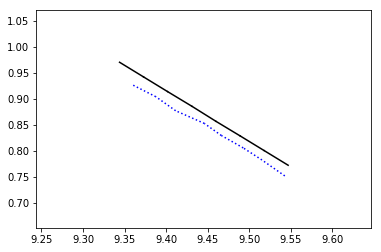

In [38]:
close_visualize(model,input_batch_padded,target_batch_padded,INPUT_LENGTH)

In [39]:
# get an overview of the prediction given the whole scene...
def visualize_batch_overview(input_batch_padded, target_batch_padded, filename = 'overview.png'):

    params, loss = model.predict([input_batch_padded,target_batch_padded])
    # visualize the trace, as well as the distributions generated by the params...
    # first clear the previous drawing...
    #     try:
    plt.gcf().clear()
    visualize_trace(input_batch,target_batch)
    #     params = params[:,INPUT_LENGTH + 1, :] # (B,5), and it should be the params immediately after the input
    #     draw_heatmap(params)
    draw_mean(params)
    plt.savefig(filename)

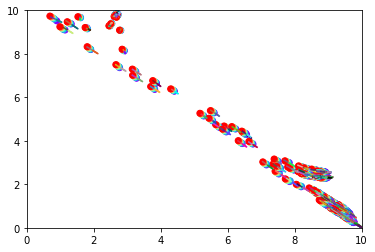

In [40]:
visualize_batch_overview(input_batch_padded, target_batch_padded)